In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision

from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

# In this script, we will focus on generating an image
# that attempts to match the content of one input image
# and the style of another input image.
#
# We accomplish this by balancing the content loss
# and style loss simultaneously.

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from skimage.transform import resize


Using TensorFlow backend.


In [0]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from scipy.optimize import fmin_l_bfgs_b


In [0]:
def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)

  return new_model

In [0]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  new_model = Sequential()
  n = 0
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    new_model.add(layer)
    if n >= num_convs:
      break

  return new_model


In [0]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

In [0]:
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G

In [0]:
def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


# let's generalize this and put it into a function
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]

In [0]:
# load the content image
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

In [0]:
content_img = load_img_and_preprocess(
  # '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg',
  # 'batman.jpg',
  '/content/drive/My Drive/Neural Style Transfer/golden_bridge.jpg',
  # (225, 300),
)

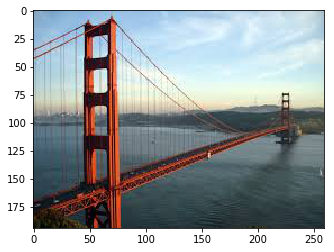

In [32]:
img = image.load_img('/content/drive/My Drive/Neural Style Transfer/golden_bridge.jpg', target_size=shape)
plt.imshow(img)

In [0]:
# resize the style image
# since we don't care too much about warping it
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
  # 'styles/starrynight.jpg',
  # 'styles/flowercarrier.jpg',
  # 'styles/monalisa.jpg',
  '/content/drive/My Drive/Neural Style Transfer/vangogh.jpg',
  (h, w)
)

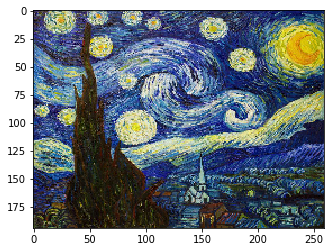

In [33]:
img = image.load_img('/content/drive/My Drive/Neural Style Transfer/vangogh.jpg', target_size=shape)
plt.imshow(img)

In [15]:
# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]


# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)


In [0]:
# create the content model
# we only want 1 output
# remember you can call vgg.summary() to see a list of layers
# 1,2,4,5,7-9,11-13,15-17
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

In [0]:
vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 2448, 3264, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 2448, 3264, 64)    36928     
_________________________________________________________________
average_pooling2d_6 (Average (None, 1224, 1632, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 1224, 1632, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 1224, 1632, 128)   147584    
_________________________________________________________________
average_pooling2d_7 (Average (None, 612, 816, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 612, 816, 256)    

In [0]:
# create the style model
# we want multiple outputs
# we will take the same approach as in style_transfer2.py
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

In [0]:
# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)


In [0]:
# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]


In [0]:
# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [0.2,0.4,0.3,0.5,0.2]


In [0]:

# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

In [0]:
for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])


In [0]:
# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

In [0]:
# just like theano.function
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)


In [0]:
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


In [0]:
from datetime import datetime

iter=0, loss=3256.96484375
iter=1, loss=726.6080322265625
iter=2, loss=433.3844909667969
iter=3, loss=343.9107666015625
iter=4, loss=300.766357421875
iter=5, loss=272.45062255859375
iter=6, loss=252.6168212890625
iter=7, loss=237.10960388183594
iter=8, loss=224.6690673828125
iter=9, loss=214.3050994873047
duration: 0:05:34.567600


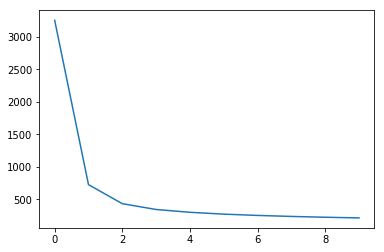

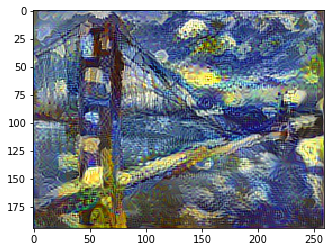

In [27]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()
